In [2]:
!pip install easycolab
import easycolab as ec
ec.mount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Opening directory /content/gdrive/My Drive/
Done!


In [2]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz -P data/
!cd data/ && tar -xf facades.tar.gz

--2021-12-27 17:07:26--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘data/facades.tar.gz.3’

facades.tar.gz.3    100%[===================>]  28.77M  2.41MB/s    in 20s     

2021-12-27 17:07:46 (1.41 MB/s) - ‘data/facades.tar.gz.3’ saved [30168306/30168306]



In [ ]:
! mkdir data/facades/train/0
! mv data/facades/train/*.jpg data/facades/train/0
! mkdir data/facades/val/0
! mv data/facades/val/*.jpg data/facades/val/0
! mkdir data/facades/test/0
! mv data/facades/test/*.jpg data/facades/test/0

In [1]:
import matplotlib.pyplot as plt
import os
import sys
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [3]:
path = 'data/facades'
train_path = path + "/train/0"

Populating the interactive namespace from numpy and matplotlib


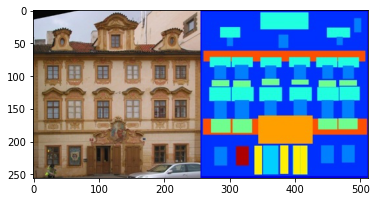

In [41]:
# %pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread(train_path + "/60.jpg")
# imgplot = plt.imshow(img)
# plt.show()

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 1
image_size = 256
num_workers = 2
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
         std=[1., 1., 1.]
         ),
])

In [5]:
class FacadesImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        _chunk_num=2
        _dim = 2
        _path, _ = self.samples[index]
        X = self.loader(_path)
        if self.transform:
            X = self.transform(X)
        return torch.chunk(X, chunks=_chunk_num, dim=_dim)

In [30]:
# !rm -rf data/facades/train/.ipynb_checkpoints

In [32]:
# !rm -rf data/facades/test/.ipynb_checkpoints
# !rm -rf data/facades/val/.ipynb_checkpoints

In [6]:
train_data = FacadesImageFolder(root=os.path.join(path, "train"), transform=preprocess)

train_loader = DataLoader(
    train_data,
     batch_size=batch_size,
      shuffle=True,
       num_workers=num_workers
       )

In [7]:
val_data = FacadesImageFolder(root=os.path.join(path, "val"), transform=preprocess)

val_loader = DataLoader(
    val_data,
     batch_size=batch_size,
      shuffle=False,
       num_workers=num_workers
       )

In [8]:
class ContrUnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2,padding=1, with_norm=False, with_droput=False, with_maxpool=False):
        super().__init__()
        sequence = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)]
        if with_norm:
          sequence.append(nn.BatchNorm2d(out_channels))
        if with_maxpool:
          sequence.append(nn.MaxPool2d((2, 2)))
        if with_droput:
          sequence.append(nn.Dropout2d(0.5))
        sequence.append(nn.LeakyReLU(0.2))
        self.convs = nn.Sequential(*sequence)

    def forward(self, x):
        out = self.convs(x)
        return out
      

In [9]:
class ExpUnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, with_norm=False, with_dropout=False):
        super().__init__()
        sequence = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), nn.ReLU()]
        if with_norm:
          sequence.append(nn.BatchNorm2d(out_channels))
        if with_dropout:
          sequence.append(nn.Dropout2d(0.5))
        self.deconvs = nn.Sequential(*sequence)
        
    def forward(self, x):
        return self.deconvs(x) 

In [10]:
class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        self.contrast_blocks = nn.ModuleList([
            ContrUnetBlock(3, n_base_channels),
            ContrUnetBlock(n_base_channels, n_base_channels * 2, with_norm=True),
            ContrUnetBlock(n_base_channels * 2, n_base_channels * 4, with_norm=True),
            ContrUnetBlock(n_base_channels * 4, n_base_channels * 8, with_norm=True),
            ContrUnetBlock(n_base_channels * 8, n_base_channels * 8, with_norm=True, with_droput=True),
            ContrUnetBlock(n_base_channels * 8, n_base_channels * 8, with_norm=True),
            ContrUnetBlock(n_base_channels * 8, n_base_channels * 8, with_droput=True),
        ])
        self.expand_blocks = nn.ModuleList([
            ExpUnetBlock(n_base_channels * 8, n_base_channels * 8, with_norm=False, with_dropout=True),
            ExpUnetBlock(n_base_channels * 16, n_base_channels * 8, with_norm=True, with_dropout=True),
            ExpUnetBlock(n_base_channels * 16, n_base_channels * 8, with_norm=True),
            ExpUnetBlock(n_base_channels * 16, n_base_channels * 4, with_norm=True),
            ExpUnetBlock(n_base_channels * 8, n_base_channels * 2, with_norm=True),
            ExpUnetBlock(n_base_channels * 4, n_base_channels * 1, with_norm=False),
        ])
        self.final_block = nn.ConvTranspose2d(n_base_channels * 1, 3, kernel_size=4, stride=2, padding=1)
            
        
    def forward(self, x):
        out = x
        outputs = []
        for i, block in enumerate(self.contrast_blocks):
            out = block(out)
            outputs.append(out)
        for i, block in enumerate(self.expand_blocks[:-1]):   
            out = block(out)
            out = torch.cat((out, outputs[-i - 2]), axis=1)

        out = self.expand_blocks[-1](out)
        out = self.final_block(out)
        return out

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, n_base_channels=64, kernel_size=4, strides=2, padding=1):
        super().__init__()
        self.blocks = nn.ModuleList([
            ContrUnetBlock(in_channels * 2, n_base_channels, kernel_size, strides, padding),
            ContrUnetBlock(n_base_channels * 1, n_base_channels * 2, kernel_size, strides, padding, with_norm=True),
            ContrUnetBlock(n_base_channels * 2, n_base_channels * 4, kernel_size, strides, 1, with_norm=True),
            ContrUnetBlock(n_base_channels * 4, n_base_channels * 8, kernel_size, strides//2 , 1, with_norm=True),
            ContrUnetBlock(n_base_channels * 8, 1, kernel_size, strides//2, 0)
        ])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], axis=1)
        for i, block in enumerate(self.blocks):
            x = block(x)
        out = self.sigmoid(x)
        return out

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.xavier_normal_(m.weight.data)

In [13]:
generator = Unet(n_base_channels=64).to(device)
discriminator = Discriminator().to(device)

In [14]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (blocks): ModuleList(
    (0): ContrUnetBlock(
      (convs): Sequential(
        (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): ContrUnetBlock(
      (convs): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): ContrUnetBlock(
      (convs): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): ContrUnetBlock(
      (convs): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

In [15]:
beta1, beta2 = 0.5, 0.999
generator_optim = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(beta1, beta2))
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(beta1, beta2))

In [16]:
def discr_loss_func(discr, real_val, fake_val, x):
    pred_real = discr(real_val, x)
    pred_fake = discr(fake_val, x)
    return criterion(
        pred_real,
        torch.ones_like(pred_real)) + criterion(pred_fake, torch.zeros_like(pred_fake)) / 2

In [17]:
def gener_loss_func(pred_fake):
    return criterion(pred_fake, torch.ones_like(pred_fake))

In [18]:
def discriminator_train(discriminator, generator, real_val, x):
    fake_val = generator(x)
    discriminator_optim.zero_grad()
    loss = discr_loss_func(discriminator, real_val, fake_val, x)
    loss.backward()
    discriminator_optim.step()
    return loss.item()

In [19]:
def generator_train(discriminator, generator,real_val, x):
    fake_val = generator(x)
    generator_optim.zero_grad()
    fake_pred = discriminator(fake_val, x)
    loss = gener_loss_func(fake_pred)
    loss_rec = criterion_reconstr(real_val, fake_val) 
    loss += 100 * loss_rec
    loss.backward()
    generator_optim.step()
    return loss.item()

In [20]:
criterion = nn.BCEWithLogitsLoss()
criterion_reconstr = nn.L1Loss()

In [21]:
loss_discr_data, loss_gen_data = list(), list()

In [22]:
epoch_num = 30

In [ ]:
for epoch in range(1, epoch_num):
    generator.train(True)
    discriminator.train(True)
    for x, y in tqdm(train_loader):
        y = y.to(device)
        x = x.to(device)
        real_x = x.clone()
        discr_loss = discriminator_train(discriminator, generator, real_x, y)
        gen_loss = generator_train(discriminator, generator, real_x, y)

    loss_discr_data.append(discr_loss)
    loss_gen_data.append(gen_loss)
    clear_output(True)
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        y = val_data[0][1]
        y = y.to(device).unsqueeze(0)
        img = generator(y)
        img = torch.clamp(img, min=0, max=1)
        plt.figure(figsize=(8,5))
        plt.subplot(1,2,1)
        plt.title("Gen, discr loss")
        plt.ylabel('Loss')
        plt.xlabel('EpochNum')
        last_discr_val, last_gen_val = loss_discr_data[-1], loss_gen_data[-1]
        plt.plot(loss_discr_data, label='Loss discr: {:.4f}'.format(last_discr_val))
        plt.plot(loss_gen_data, label='Loss gen: {:.4f}'.format(last_gen_val))
        plt.legend()
        plt.subplot(1,2,2)
        plt.title("Fake")
        plt.imshow(img.cpu().detach().numpy().transpose([0, 2, 3, 1])[0])    
        plt.show()


  0%|          | 0/400 [00:00<?, ?it/s]